### 1. Data preparation

In [1]:
import pandas as pd

# Load data
checkin_data = pd.read_csv("../data/_raw/checkin_checkout_history_updated.csv", parse_dates= ['checkin_time', 'checkout_time'])
gym_data = pd.read_csv("../data/_raw/gym_locations_data.csv")
user_data = pd.read_csv("../data/_raw/users_data.csv")

workout_data = checkin_data.merge(user_data[['user_id', 'age', 'gender']], on='user_id', how='left')
workout_data = workout_data[['workout_type', 'age', 'gender', 'checkin_time', 'checkout_time']]

### 2. Standardizing the data

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

workout_label_encoder = LabelEncoder()
gender_label_encoder = LabelEncoder()
workout_data['workout_type_standardized'] = workout_label_encoder.fit_transform(workout_data['workout_type'])
workout_data['gender_standardized'] = gender_label_encoder.fit_transform(workout_data['gender'])

#scaler = StandardScaler()
#workout_data[['age']] = scaler.fit_transform(workout_data[['age']])
#workout_data.dropna(inplace=True)

### 3. Data Split

Splitting data into test and training data

In [3]:
from sklearn.model_selection import train_test_split

# Define variables and target
X = workout_data[['age', 'gender_standardized']]
y = workout_data['workout_type_standardized']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Classification

Logistic Regression Classification is a statistical algorithm.
It is a binary classification, evaluation the accucary of the prediction model by determining True Positives (TP), True Negative (TN), False Positives (FP) and False Negatives (FN)

Logistic Regression Accuracy: 0.16721666666666668


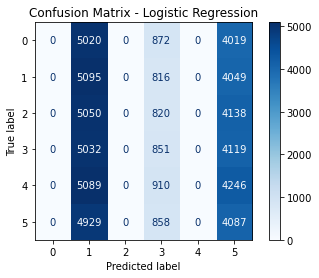

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train Logistic Regression model for comparison
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# Predictions
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate Logistic Regression model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))

# Confusion matrix
unique_labels = sorted(set(y_test))
confusion_matrix = confusion_matrix(y_test, y_pred_logistic, labels=unique_labels)
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=unique_labels)
display.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

The confusion matrix shows the performance of the logistic regression in predicting workout types based on age and gender.
The model isn't good at differentiating between the workout types effectively. 

# Decision Tree Classification

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


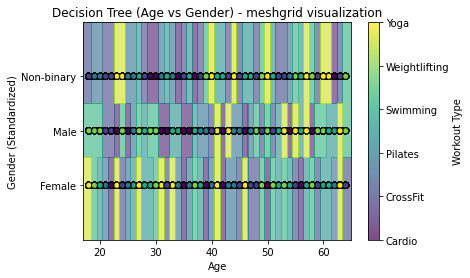

In [5]:
from matplotlib.colors import ListedColormap 
from sklearn.tree import DecisionTreeClassifier 
import numpy as np 
import matplotlib.pyplot as plt

# Train the Decision Tree model (if not done already)
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Predictions
y_pred_tree = tree_model.predict(X_test)

# Create a grid for decision tree visualization
# Defining the boundaries:
x_min, x_max = X_test['age'].min() - 1, X_test['age'].max() + 1
y_min, y_max = X_test['gender_standardized'].min() - 1, X_test['gender_standardized'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict "on" the grid to create the decision tree
Z = tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision tree
plt.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.viridis)

# Plot predictions
scatter = plt.scatter(
    X_test['age'], X_test['gender_standardized'], c=y_pred_tree, cmap=plt.cm.viridis, alpha=0.7, edgecolors='k'
)

# Add a colorbar with workout type labels
workout_labels = workout_label_encoder.inverse_transform(np.unique(workout_data['workout_type_standardized']))
colorbar_new = plt.colorbar(scatter, ticks=range(len(workout_labels)))
colorbar_new.ax.set_yticklabels(workout_labels)
colorbar_new.set_label("Workout Type")

# Add plot labels and title
plt.title("Decision Tree (Age vs Gender) - meshgrid visualization")
plt.xlabel("Age")
plt.ylabel("Gender (Standardized)")
plt.yticks(ticks=[0, 1, 2], labels=["Female", "Male", "Non-binary"])
plt.show()

The decision tree predicts for each "case", what workout category they are classified into.
E.g. a 19 year old female is categorized into the swimming category, while a 31 year old is categorized into a combination of yoga and weightlifting. 

In [6]:
# Evaluate Decision Tree again for comparison
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))

Decision Tree Accuracy: 0.166


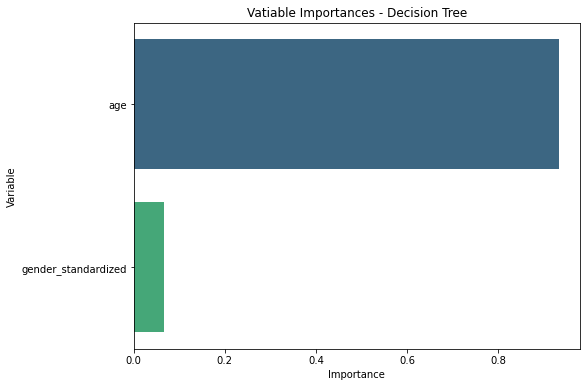

In [7]:
import seaborn as sns

# Plot what variables from the Decision Tree are most important
feature_importances = pd.DataFrame({
    'Variable': X.columns,
    'Importance': tree_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importances, x='Importance', y='Variable', palette='viridis')
plt.title("Vatiable Importances - Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.show()

The plot above shows that the variable 'age' contributes most to predicting the workout type.